Functionality relating to running the whole script from terminal was commented out.

The body of the main function was moved outside for access to variables for debugging and testing.

Channel Polarization fraction is calculated with channel P and channel Stokes I, not MFS I

Assumi

In [ ]:
"""
polarization.py combines the Q and U images produced by wsclean into a MFS P image and writes it to a FITS file, as well as a polarization fraction image.
If [-pathI] is provided, wscleanP will calculate a polarization fraction image

example use case, run in wd ASKAP Table 1 Data
python polarization.py 'sb44780/SB44780QU' 'sb44780/SB44780I-MFS-image.fits' 6 'sb44780/SB44780'

example use case, run in wd ASKAP
python polarization.py 'data/SB44780/imageQU/SB44780' 'data/SB44780/image/SB44780-MFS-image.fits' 72 '44780/SB44780'

We assume polarized intensity to noise ratio < 4. (George et al. 2012)
We find polarization fraction at the location of highest polarized intensity, which does not give the highest polarization fraction.
"""

# constants and import
import argparse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
from scipy.ndimage import label

# # Function to parse arguments from command line
# def parse_arguments():
#     """Parse command-line arguments."""
#     parser = argparse.ArgumentParser(description="Combines the Q and U images produced by wsclean into P images.")
#     parser.add_argument("pathQU", help="If a file path to an image is 'sb44780/SB44780QU-0000-Q-image.fits' then set pathQU='sb44780/SB44780QU'")
#     parser.add_argument("pathI", help="Provide the full file path to the MFS I image FITS file'")
#     parser.add_argument("channels", type=int, help="Specify number of channels used in wsclean")
#     parser.add_argument("saveto", help="If a desired file path is 'sb44780/SB44780-MFS-P-image.fits' then set saveto='sb44780/SB44780'")
#     return parser.parse_args()


pathQU, pathI, pathCat = 'sb44780/SB44780QU', 'sb44780/SB44780I-MFS-image.fits', "consolidated_catalog_ver1.2.0.fits"
channels, saveto, emptyRegionRange = 6, 'sb44780/SB44780', 'slice(640, 860), slice(980, 1390)'
# for a 2D numpy array from a FITS file, the first index is y (dec) and the second index is x (ra)
# def calculateP(pathQU, pathI, channels, saveto):

# TODO smooth Q and U images to lowest resolution before combining, see CASA command
# FIXME sources seem brighter (in total intensity) in the catalogue than in our field. Might be something wrong with the flux scale, 
# flux density off factor varies from .5 to .3 for 44780 6 channels, the pbr 2d gaussian and XX + YY != .5*(XX+YY) may be the culprits
# TODO verbose parameter to handle saving diagnostic plots
# WARNING running previous cells twice throws a PermissionError, suggesting FITS files are kept open. I double checked, and with fits.open should automatically be closing them.

# minimum SNR ratios for masking 
PSNR = 5
ISNR = 100 # TODO, add to parameters
antennaDiameter = 12 # metres, antenna diameter for FWHM
emptyRegionRange = eval(emptyRegionRange)

# read in Stokes I MFS image and Header
with fits.open(pathI) as hdulI:
    dataI = hdulI[0].data[0,0] # Change the shape from (1,1,n,n) to (n,n)
    headerI = hdulI[0].header
degPerPix = abs(headerI['CDELT1']) # degrees per pixel of image, assuming it is same for both axes
imageLenX = headerI['NAXIS1'] # number of pixels along this axis
imageLenY = headerI['NAXIS2'] # these might be reversed, but the image is square so it's fine for this case
x = np.arange(-imageLenX // 2, imageLenX // 2)
y = np.arange(-imageLenY // 2, imageLenY // 2)
x, y = np.meshgrid(x, y)
obsFreq = headerI['CRVAL3']
obsFWHM = np.degrees(1.09 * c / obsFreq / antennaDiameter) # coefficient from https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S1323358020000417
obsPBRsigma = obsFWHM / 2.35482004503 # coefficient from https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/
obsPBR =  np.exp(-(x**2 + y**2) / (2 * (obsPBRsigma/degPerPix)**2))
obsPBR /= obsPBR.max()

dataI /= obsPBR # correct the Stokes I MFS image for primary beam response
# # DIAGNOSTIC STEP, save the primary beam corrected MFS I image
# hdu = fits.PrimaryHDU(dataI, header=headerI) 
# hdu.writeto(f'{saveto}-MFS-I-pbrcorrected-image.fits', overwrite=True)

# mask dataI values below SNR of ISNR
Imask = np.where(dataI < ISNR * dataI[emptyRegionRange].std(), np.nan, 1)
dataImasked = dataI * Imask
# identify clusters (bright sources) in the Stokes I image
# labeled_array is 0 for no clusters, 1 for pixels belonging to the first cluster, 2 for pixels belonging to the 2nd cluster, etc
labeled_array, num_clusters = label(~np.isnan(Imask)) # TODO only uses I mask, to use MFS P mask there needs to be a second for loop, 
# a few more sources near the edge were detected due to PBR correction as they shot up past the SNR cutoff

In [ ]:
# read in pol catalogue
polCat = Table.read(pathCat)

# Define the WCS of the image
wcs = WCS(headerI).celestial

# Define the pixel coordinates of the image edges
imageRangeX = np.array([0, imageLenX])
imageRangeY = np.array([0, imageLenY]) 

# Convert pixel coordinates to world coordinates (RA, Dec) in degrees
[raMax, raMin], [decMin, decMax] = wcs.all_pix2world(imageRangeX, imageRangeY, 0)

# Filter the table
# ra was negative, we add 360 to get it in the 0-360 range
mask = ((polCat['ra'] >= raMin + 360) & (polCat['ra'] <= raMax + 360) & (polCat['dec'] >= decMin) & (polCat['dec'] <= decMax))
polCatMasked = polCat[mask] # 3 sources in the catalog within our image, the last two are likely different observatorys' entries of the same source

# Convert RA and Dec of polarized sources to pixel coordinates
catSourceXpixs, catSourceYpixs = wcs.all_world2pix(polCatMasked['ra'], polCatMasked['dec'], 0)

# Read Stokes I, polarization intensity, polarization fraction, frequency, and rotation measure from catalog
catSourceIs = polCatMasked['stokesI']
catSourcePs = polCatMasked['polint']
catSourcePolFracs = polCatMasked['fracpol']
catSourceFreqs = np.array([(1435100000.0+1364900000.0)/2, (1435100000.0+1364900000.0)/2, 1420780900.0])/1e0 #FIXME not generalized, only 1 catalog source has a given reference frequency
catSourceRMs = polCatMasked['rm'] # units of radians per metre squared
# Catalog sources are matched to clusters by eye. This can be automated but would scale O(n^2) with catalog length.
beamCatalogPairIDs = [21,66] # TODO automate matching catalog sources to image sources 


In [3]:
# Initialize per channel arrays
channelPs = np.empty((channels, imageLenX, imageLenY))
channelFreqs = np.empty(channels)
channelPolAngles = np.empty((len(beamCatalogPairIDs), channels))
channelWavelengths = np.empty(channels)
channelSourceIs = np.empty((len(beamCatalogPairIDs), channels))
channelSourcePs = np.empty((len(beamCatalogPairIDs), channels))
channelSourcePfracs = np.empty((len(beamCatalogPairIDs), channels))
FWHMs = np.empty(channels) # full width half maximum, converted to degrees
PBsigmas = np.empty(channels) # primary beam response sigma 

for i in range(channels):

    # Format number to be a string literal of a 4 digit int, padded with zeros
    number = f"{i:04d}"

    # read in Q_i and copy its header, shape is (1,1,n,n)
    with fits.open(f"{pathQU}-{number}-Q-image.fits") as hdulQ:
        dataQ = hdulQ[0].data[0,0]  # Assuming the data is in the primary HDU
        headerQ = hdulQ[0].header  
        freqQ = headerQ['CRVAL3'] # Hz

    # read in U_i
    with fits.open(f"{pathQU}-{number}-U-image.fits") as hdulU:
        dataU = hdulU[0].data[0,0]  # Assuming the data is in the primary HDU

    # Ensure the two datasets have the same shape
    if dataQ.shape != dataU.shape:
        raise ValueError("The Q and U FITS files must have the same dimensions.")
    
    # Append channel frequency, calculate channel wavelength, FWHM, and primary beam response sigma
    channelFreqs[i] = freqQ
    channelWavelengths[i] = c/freqQ
    FWHMs[i] = np.degrees(1.09 * channelWavelengths[i] / antennaDiameter) # coefficient from https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S1323358020000417
    PBsigmas[i] = FWHMs[i] / 2.35482004503 # coefficient from https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/

    # Produce a primary beam response image
    pbresponse = np.exp(-(x**2 + y**2) / (2 * (PBsigmas[i]/degPerPix)**2)) # assuming a circular gaussian
    pbresponse /= pbresponse.max() # normalize
    # hdu = fits.PrimaryHDU(pbresponse, header=headerI) 
    # hdu.writeto(f'{saveto}-{number}-pbresponse-image.fits', overwrite=True)

    # Compute stokes P square root of the sum of the squares and append to the array
    # Subtract off Riccian bias on each channel (STD and RMS are similar)
    # Correct for primary beam response
    channelP = np.sqrt(dataQ**2 + dataU**2) - dataQ[emptyRegionRange].std()/2 - dataU[emptyRegionRange].std()/2 # assuming uncorrected P < 4 * sigma_QU
    # channelP = np.sqrt(dataQ**2 + dataU**2 - 2.3/4 * (dataQ[emptyRegionRange].std() + dataU[emptyRegionRange].std())**2) # assuming uncorrected P > 4 * sigma_QU
    channelP /= pbresponse
    channelPs[i] =  channelP 

    # read in channel Stokes I image 
    # calculate Stokes I, Stokes P, polarization fraction, polarization angle for each source for each image
    with fits.open(f'{saveto}I-{number}-image.fits') as hdulChannelI: 
        dataChannelI = hdulChannelI[0].data[0,0] / pbresponse # correct for primary beam response
    # channel Stokes I have matching frequencies to Stokes Q, they are correct and not flipped
    for j, sourceID in enumerate(beamCatalogPairIDs):
        channelSourceIs[j, i] = np.max(dataChannelI[labeled_array == sourceID])
        maxIndex = np.argmax(channelP[labeled_array == sourceID])
        # channelSourcePs[j, i] = np.max(channelP[labeled_array == sourceID]) 
        # channelSourcePfracs[j, i] = np.max((channelP/dataChannelI)[labeled_array == sourceID]) 
        channelSourcePs[j, i] = channelP[labeled_array == sourceID][maxIndex]
        channelSourcePfracs[j, i] = (channelP/dataChannelI)[labeled_array == sourceID][maxIndex] 
        channelPolAngles[j, i] = np.arctan2(dataU[labeled_array == sourceID][maxIndex], dataQ[labeled_array == sourceID][maxIndex]) / 2
    


    # Save each P_i/I image to check leakage
    # Could save P_i/I as an image cube using P_i/dataI instead but this may overwrite headers
    headerQ['CRVAL1'] += 360 # ra was negative, this fixes it to 0-360 range
    headerQ['CRVAL4'] = 4 # set the Stokes parameter to 4 (P)
    # mask values below PSNR or ISNR
    hdu = fits.PrimaryHDU(channelP/dataChannelI, header=headerQ) 
    hdu.writeto(f'{saveto}-{number}-Pfrac-image.fits', overwrite=True)

    # Output that P_i was successfully computed and appended
    # print(f'Q_{i} MS = {Q_ms} and U_{i} MS = {U_ms} for channel {i}')
    print(f'Successfully calculated P and saved P/I to `{saveto}-{number}-Pfrac-image.fits` for channel {i}.')
    

# stack P_i into an array of shape (channels,n,n) before averaging over channels
# mask dataP values below SNR of PSNR
dataP = np.mean(np.stack(channelPs, axis=0), axis=0)
Pmask = np.where(dataP < PSNR * dataP[emptyRegionRange].std(), np.nan, 1)
dataPmasked = dataP * Pmask

# DISABLED, Riccean bias is corrected at the channel level
# # Correct for Riccean bias, subtract off the average of noise from the MFS of Q and U
# with fits.open(f"{pathQU}-MFS-Q-image.fits") as hdulQMFS:
#     dataQMFS = hdulQMFS[0].data
# with fits.open(f"{pathQU}-MFS-U-image.fits") as hdulUMFS:
#     dataUMFS = hdulUMFS[0].data
# QUnoise = np.std(dataQMFS[0,0])/2 + np.std(dataUMFS[0,0])/2   # RMS and STD give similar values
# dataP[0,0] -= QUnoise

# Save dataP to a new FITS file with mean channel frequency and Stokes 4
headerQ['CRVAL3'] = np.mean(channelFreqs)
hdu = fits.PrimaryHDU(dataP, header=headerQ) 
hdu.writeto(saveto+'-MFS-P-image.fits', overwrite=True)
print(f"P image saved to `{saveto}-MFS-P-image.fits`")

# Save P/I MFS to a new FITS file with mean channel frequency and Stokes 4
fracP = dataPmasked/dataImasked
hdu = fits.PrimaryHDU(fracP, header=headerQ) 
hdu.writeto(saveto+'-MFS-Pfrac-image.fits', overwrite=True)
print(f"P/I image saved to `{saveto}-MFS-Pfrac-image.fits`")

# DISABLED, not a useful image
# Plot masked P/I image, save, close
# plt.figure(figsize=(8, 6), facecolor='gray');
# plt.imshow(fracP, origin='lower', vmin=0, vmax=1, cmap='viridis')
# plt.colorbar(label='Polarization fraction')
# plt.title(f'Mask out pixels of P < {PSNR}*noise of P and I < {ISNR}*noise of I')
# plt.xticks([]) 
# plt.yticks([])
# plt.savefig(f'{saveto}-MFS-Pfrac-image.png', bbox_inches='tight')
# print(f"P/I image saved to `{saveto}-MFS-Pfrac-image.png`")
# plt.close()

# # Main function
# def main():
#     """Execute the script."""
#     args = parse_arguments()
#     calculateP(args.pathQU, args.pathI, args.channels, args.saveto)

# # Entry point, run the script when run from terminal
# if __name__ == "__main__":
#     main()

Successfully calculated P and saved P/I to `sb44780/SB44780-0000-Pfrac-image.fits` for channel 0.
Successfully calculated P and saved P/I to `sb44780/SB44780-0001-Pfrac-image.fits` for channel 1.
Successfully calculated P and saved P/I to `sb44780/SB44780-0002-Pfrac-image.fits` for channel 2.
Successfully calculated P and saved P/I to `sb44780/SB44780-0003-Pfrac-image.fits` for channel 3.
Successfully calculated P and saved P/I to `sb44780/SB44780-0004-Pfrac-image.fits` for channel 4.
Successfully calculated P and saved P/I to `sb44780/SB44780-0005-Pfrac-image.fits` for channel 5.
P image saved to `sb44780/SB44780-MFS-P-image.fits`
P/I image saved to `sb44780/SB44780-MFS-Pfrac-image.fits`


Decimal fraction of non nan values 0.00017, (0.017%)


C:\Users\hanyu\AppData\Local\Temp\ipykernel_4748\701019942.py:21: RuntimeWarning: All-NaN slice encountered
  max_value = np.nanmax(cluster_values)


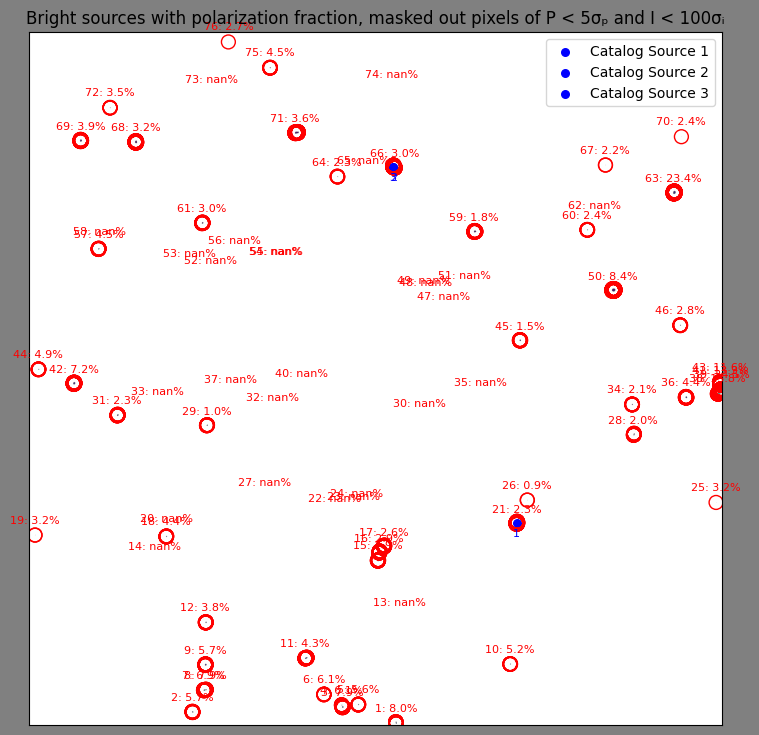

In [24]:
# Plot masked P frac and circle non masked pixels 

print(f'Decimal fraction of non nan values {np.count_nonzero(~np.isnan(fracP)) / fracP.size:.2g}, ({np.count_nonzero(~np.isnan(fracP)) / fracP.size*100:.2g}%)')

plt.figure(figsize=(12, 9), facecolor='gray')
plt.imshow(fracP, origin='lower', vmin=None, vmax=None, cmap='viridis') # origin='lower' is how DS9 views images

for i in range (1, len(catSourceXpixs)+1):
    plt.scatter(catSourceXpixs[i-1], catSourceYpixs[i-1], color='blue', s=30,  facecolors='blue', label=f'Catalog Source {i}')
    plt.text(catSourceXpixs[i-1], catSourceYpixs[i-1]-50, f'{i}', color='blue', fontsize=8, ha='center', va='center')
# plt.colorbar(label='Polarization fraction')
plt.title(f'Bright sources with polarization fraction, masked out pixels of P < {PSNR}σₚ and I < {ISNR}σᵢ')
plt.legend()
plt.xticks([])
plt.yticks([]);


# Find the polarized fraction of each cluster, this is a rough calculation for all identified sources, sources with a catalog match are handled differently
for cluster_id in range(1, num_clusters + 1):
    cluster_values = fracP[labeled_array == cluster_id] 
    max_value = np.nanmax(cluster_values)

    # Label each cluster on the image
    y, x = np.argwhere(labeled_array == cluster_id)[0]  # (row, col) of the first pixel of each cluster, will be offcentre for extended sources
    # Add the cluster label near the first pixel
    plt.text(x, y+70, f'{cluster_id}: {max_value*100:.1f}%', color='red', fontsize=8, ha='center', va='center')
    # print(f'Cluster {cluster_id}: Max value = {max_value:.4f}')

# circle polarized pixels (non nan)
y, x = np.where(~np.isnan(fracP))
plt.scatter(x, y, color='red', s=100, linewidth=1, facecolors='none', label='Non-NaN Pixels'); # thickness of circle corresponds to the # of pixels in the cluster
# plt.savefig(f'{saveto}-filename-image.png', bbox_inches='tight')
# plt.close()

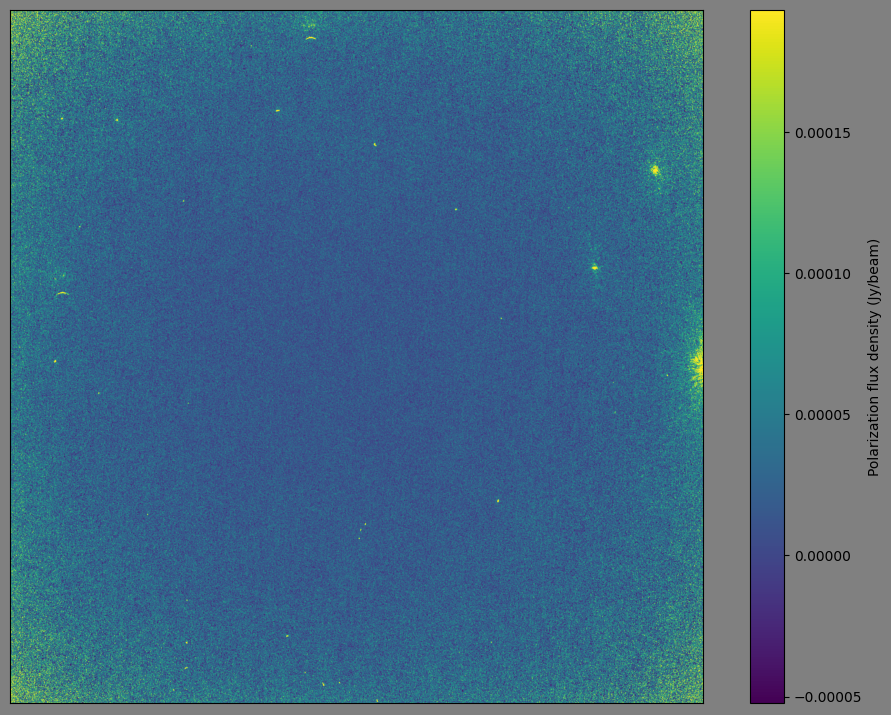

In [5]:
# Plot P flux density

# Get the optimal vmin and vmax using ZScaleInterval
vmin, vmax = ZScaleInterval().get_limits(dataP)

plt.figure(figsize=(12, 9), facecolor='gray')
plt.imshow(dataP, origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar(label='Polarization flux density (Jy/beam)')
plt.xticks([])
plt.yticks([]);

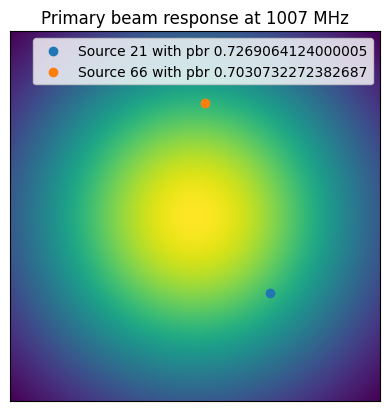

In [6]:
# Plot the final primary beam response, which has the furthest from uniform 2d gaussian
# Plot the locations of sources 
# Print the pbm response for each source
plt.imshow(pbresponse, origin='lower')
for x,y,label in zip(catSourceXpixs[:-1], catSourceYpixs[:-1], beamCatalogPairIDs):
    plt.scatter(x,y, label=f'Source {label} with pbr {pbresponse[round(x),round(y)]}')
plt.xticks([]) 
plt.yticks([])
plt.title(f'Primary beam response at {round(channelFreqs[-1]/1e6)} MHz')
plt.legend();

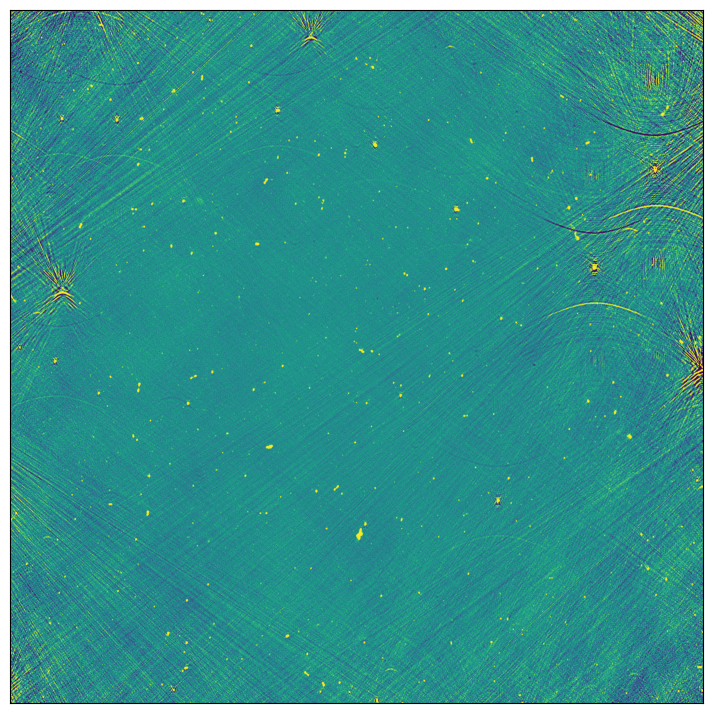

In [7]:
# Plot Stokes I flux density

plt.figure(figsize=(12, 9))
vmin, vmax = ZScaleInterval().get_limits(dataI)
plt.imshow(dataI, origin='lower', vmin=vmin, vmax=vmax)
plt.xticks([]) 
plt.yticks([]);

In [8]:
# Plot P/I vs I for image sources and catalog sources
channelSourceIs

array([[0.14817084, 0.14053456, 0.13010532, 0.12122079, 0.11340599,
        0.10641446],
       [0.07349901, 0.07005186, 0.06479104, 0.06043245, 0.05670967,
        0.05328435]])

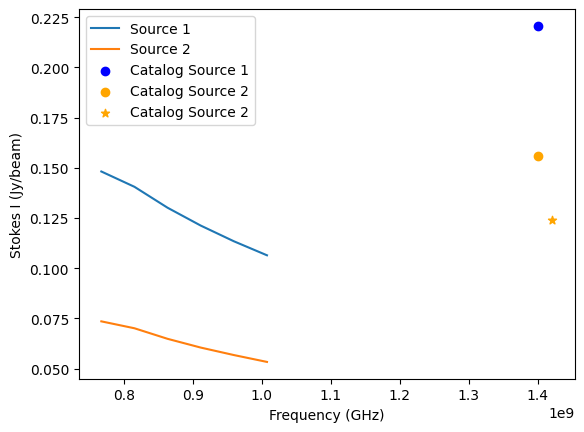

In [25]:
# Plot Stokes I over frequency for sources in field and catalog

plt.figure()
for i in range(0, len(channelSourceIs)):
    plt.plot(channelFreqs, channelSourceIs[i], label=f'Source {i+1}')  # Stokes I images produced from a different run of wsclean. Were the channels flipped somehow?

# plt.plot(channelFreqs, np.array(channelSourcePfracs).T[2], label='Source 3', ls='--')
plt.scatter(catSourceFreqs[0], catSourceIs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourceIs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourceIs[2],label='Catalog Source 2',marker='*',color='orange')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Stokes I (Jy/beam)');

In [10]:
# helper function to find peaks in a 2D array

def findPeaks(data, xCoords, yCoords, halfSize): #TODO rewrite this function to work with 2D arrays containing clusters
    """
    Find the peak value of square slices centered on given coordinates.

    Parameters:
    - data: 2D NumPy array
    - xCoords: List of x coordinates 
    - yCoords: List of y coordinates 
    - halfSize: half the side length of the square slice

    Returns:
    - List of peak values for each square slice
    """

    peakValues = []
    sourceIms = []

    for x, y in zip(xCoords, yCoords):
        sliceOfData = data[max(0, round(y) - halfSize):min(data.shape[0], round(y) + halfSize), max(0, round(x) - halfSize):min(data.shape[1], round(x) + halfSize)]
        sourceIms.append(sliceOfData)
        peakValues.append(np.nanmax(sliceOfData)) # TODO error catching for RuntimeWarning: All-NaN slice encountered

    return peakValues, sourceIms

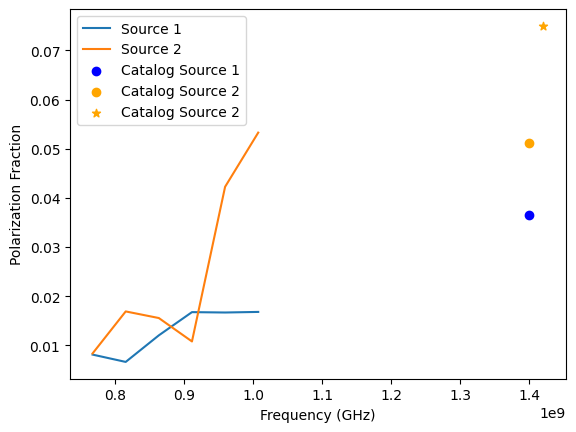

In [26]:
# Plot P/I over frequency for sources in field and catalog
# TODO plot MFS as well and then fit an exponential to find sigma_rm
# TODO ask Erik what he meant by plotting A.4 for typical sigma_rm

plt.figure()
for i in range(len(channelSourcePfracs)):
    plt.plot(channelFreqs, channelSourcePfracs[i], label=f'Source {i+1}')

plt.scatter(catSourceFreqs[0], catSourcePolFracs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourcePolFracs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourcePolFracs[2],label='Catalog Source 2',marker='*',color='orange')

plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Polarization Fraction');

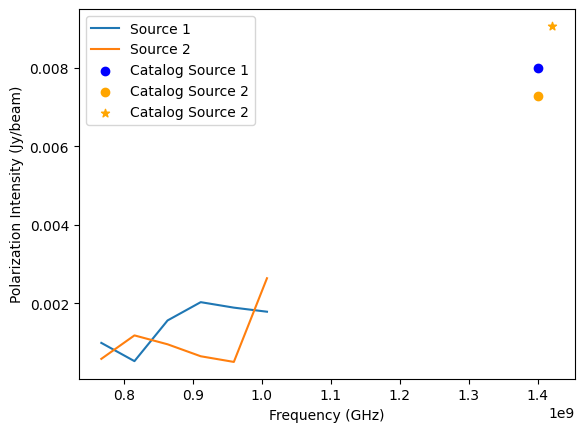

In [12]:
# Plot polarization intensity vs frequency for sources in field and catalog
# Because polarisation fraction only verifies relative flux scale of pol as ratio of total intensity, while that would verify the absolute flux scale as well
plt.figure()
for i in range(0, len(channelSourcePs)):
    plt.plot(channelFreqs, channelSourcePs[i], label=f'Source {i+1}')  # Stokes I images produced from a different run of wsclean. Were the channels flipped somehow?

# plt.plot(channelFreqs, np.array(channelSourcePfracs).T[2], label='Source 3', ls='--')
plt.scatter(catSourceFreqs[0], catSourcePs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourcePs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourcePs[2],label='Catalog Source 2',marker='*',color='orange')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Polarization Intensity (Jy/beam)');


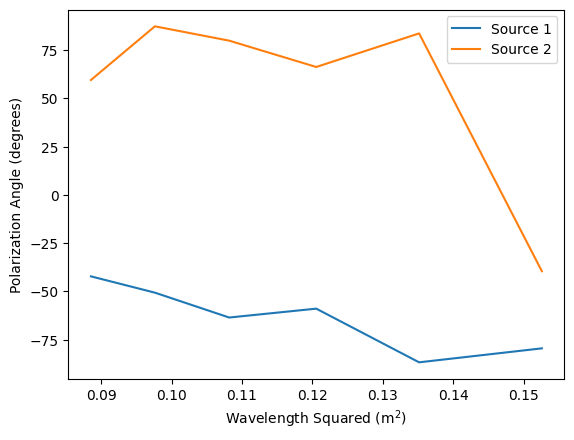

In [13]:
# plot polarization angle vs wavelength^2, as well as RM 
plt.figure()
for i in range(0, len(channelPolAngles)):
    plt.plot(channelWavelengths**2, np.degrees(channelPolAngles[i]), label=f'Source {i+1}') 
plt.xlabel(r'Wavelength Squared (m$^2$)')
plt.ylabel('Polarization Angle (degrees)')
plt.legend();

In [14]:
# used the individual maxima of Q and U at possibly different pixels

In [15]:
# plot 
# P = P0 exp (-2 * sigma_rm**2 * lambda**2)
# def 

In [16]:
#TODO install casa on device to use imsmooth

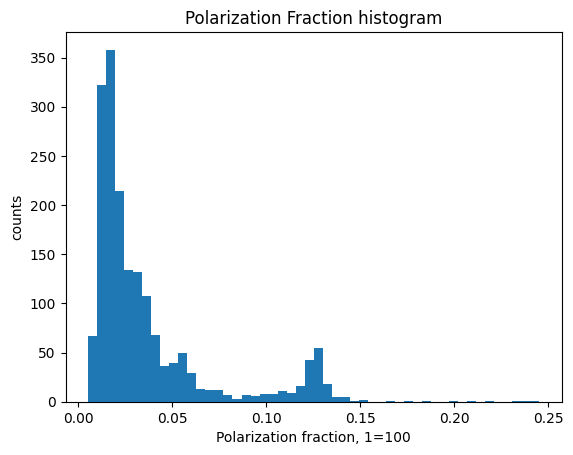

In [17]:
# plot histogram of pixels in polarization fraction image
plt.hist(fracP.flatten(),bins=50)#, range=(-.01, .05));#, alpha=0.8);
plt.title('Polarization Fraction histogram')
plt.ylabel('counts')
plt.xlabel('Polarization fraction, 1=100');